<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/outliers/03_isolation_forest_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
from unicodedata import normalize

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler



# **Info**
---

**@By**: Steven Bernal

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr




# **Funciones**
---

In [ ]:
def normalize_word(word):
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns

# **Config**
---

In [ ]:
random_seed = 12354
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Valor Contraprestaciones'
paleta = sns.color_palette('Set2').as_hex()
np.set_printoptions(precision=3, suppress=True)

# **Data**
---

In [ ]:
url_materiales_mineros = 'https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'
url_materiales_mineros = 'https://drive.google.com/uc?id=' + url_materiales_mineros.split('/')[-2]
data_materiales_mineros = pd.read_csv(url_materiales_mineros, dtype='str')

In [ ]:
# Normalización de los nombres de las columnas
data_materiales_mineros.columns = normalize_name_columns(
    data_materiales_mineros.columns)

In [ ]:
data_materiales_mineros.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

In [ ]:
# Se asigna los tipos de datos reales a los datos
data_materiales_mineros[[
    'valor_contraprestacion',
    'cantidad_produccion'
]] = data_materiales_mineros[[
    'valor_contraprestacion',
    'cantidad_produccion'
]].astype('float64')

In [ ]:
# Se transforma una columna trimestre de texto a número
data_materiales_mineros[
    'trimestre'] = data_materiales_mineros[
        'trimestre'].apply(lambda x: x.split(' ')[1])

data_materiales_mineros.head(3)

,municipio_productor,departamento,recurso_natural,nombre_del_proyecto,ano_produccion,trimestre,unidad_medida,tipo_contraprestacion,valor_contraprestacion,cantidad_produccion
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,4,TONELADAS,REGALIAS,"614,258.00",0.00
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,4,TONELADAS,REGALIAS,"2,036,781.00","14,381.00"
2,Medellin,Antioquia,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,1,TONELADAS,REGALIAS,"836,927.00","16,308.00"


In [ ]:
data_materiales_mineros[[
    'trimestre',
    'ano_produccion'
]] = data_materiales_mineros[[
    'trimestre',
    'ano_produccion'
]].astype('int32')

In [ ]:
# Se tomará como periodo de datos para el entrenamiento de modelos 5 años
data_materiales_mineros = data_materiales_mineros[
    (data_materiales_mineros["ano_produccion"] >= 2018)
    &
    (data_materiales_mineros["ano_produccion"] < 2023)
    ]

In [ ]:
data_materiales_mineros['key'] = data_materiales_mineros.municipio_productor.str.cat(
    data_materiales_mineros.departamento, sep='-')

In [ ]:
# Movimiento Transacciones
function_dictionary = {
    "valor_contraprestacion": ['sum', 'count']
}

filter_feature = [
    'key',
    'ano_produccion',
    'trimestre',
    'tipo_contraprestacion']

new_val_col = [
    'valor_contraprestacion',
    'conteo_transacciones'
]


data_group = data_materiales_mineros.groupby(
    filter_feature).aggregate(function_dictionary)

data_group.columns = new_val_col
data_group = data_group.reset_index()

data_group

,key,ano_produccion,trimestre,tipo_contraprestacion,valor_contraprestacion,conteo_transacciones
0,Abejorral-Antioquia,2018,1,REGALIAS,"2,783,489.00",1
1,Abejorral-Antioquia,2018,2,REGALIAS,"3,659,452.00",1
2,Abejorral-Antioquia,2018,3,REGALIAS,"5,732,763.00",1
3,Abejorral-Antioquia,2018,4,REGALIAS,"11,706,438.00",2
4,Abejorral-Antioquia,2019,1,REGALIAS,"5,793,131.00",2
...,...,...,...,...,...,...
9638,Zona Bananera-Magdalena,2020,4,REGALIAS,"65,800.00",2
9639,Zona Bananera-Magdalena,2021,2,REGALIAS,"76,600.00",2
9640,utica-Cundinamarca,2020,4,REGALIAS,59.00,1
9641,utica-Cundinamarca,2021,4,REGALIAS,77.00,1


In [ ]:
# Movimiento Transacciones
function_dictionary = {
    "valor_contraprestacion": ['sum'],
    "conteo_transacciones": ['sum'],
    'trimestre': ['count'],
    'ano_produccion': ['nunique']
}

filter_feature = [
    'key',
    'tipo_contraprestacion']



data_group2 = data_group.groupby(
    filter_feature).aggregate(function_dictionary)

new_val_col = [
    'valor_contraprestacion',
    'numero_transacciones',
    'numero_trimestres_activos',
    'ano_produccion_activos',
]


data_group2.columns = new_val_col
data_group2 = data_group2.reset_index()

data_group2

,key,tipo_contraprestacion,valor_contraprestacion,numero_transacciones,numero_trimestres_activos,ano_produccion_activos
0,Abejorral-Antioquia,REGALIAS,"52,580,674.00",17,11,4
1,Abrego-Norte de Santander,REGALIAS,"22,530,021.00",21,16,5
2,Abriaqui-Antioquia,REGALIAS,"355,266,722.00",35,15,5
3,Acacias-Meta,REGALIAS,"607,849,192.00",58,20,5
4,Achi-Bolivar,REGALIAS,"557,468,046.00",6,3,1
...,...,...,...,...,...,...
738,Zarzal-Valle del Cauca,REGALIAS,"12,268,845.00",20,16,5
739,Zipaquira-Cundinamarca,COMPENSACIÓN,"826,249,886.00",4,2,2
740,Zipaquira-Cundinamarca,REGALIAS,"2,277,151,193.00",53,19,5
741,Zona Bananera-Magdalena,REGALIAS,"2,280,457.00",16,6,4


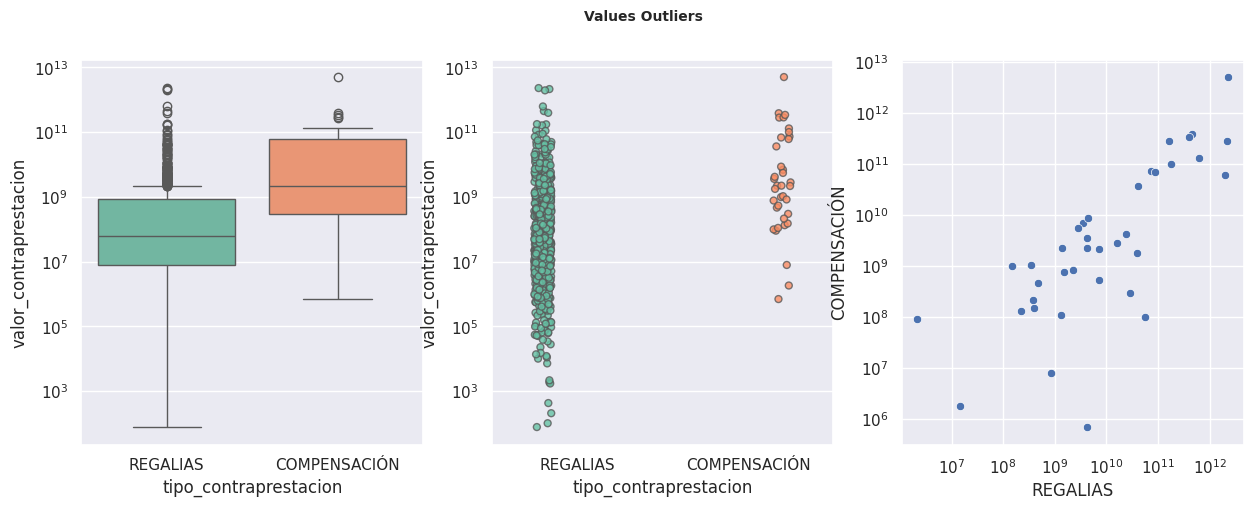

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=data_group2,
            y='valor_contraprestacion',
            x='tipo_contraprestacion',
            ax=ax[0],
            palette=paleta)
ax[0].set(yscale="log")

sns.stripplot(
    data=data_group2,
    y="valor_contraprestacion",
    x='tipo_contraprestacion',
    dodge=True,
    ax=ax[1],
    linewidth=1,
    alpha = 0.8,
    palette=paleta)
ax[1].set(yscale="log")

sns.scatterplot(data= data_group2.pivot(index='key', columns='tipo_contraprestacion', values='valor_contraprestacion'), x="REGALIAS", y="COMPENSACIÓN", ax=ax[2])
ax[2].set(yscale="log")
ax[2].set(xscale="log")

fig.suptitle('Values Outliers', fontsize = 10, fontweight = "bold");
plt.show()

# **Modelo Anomalias Univariado**
---

In [ ]:
model_aoutliers_baseic = IsolationForest(
    n_estimators= 100,
    max_samples = 'auto',
    contamination = 0.1,
    random_state  = random_seed
)
model_aoutliers_baseic.fit(X=data_group2[['valor_contraprestacion']])

IsolationForest(contamination=0.1, random_state=12354)

In [ ]:
y_predict = model_aoutliers_baseic.predict(X=data_group2[['valor_contraprestacion']])
data_group2['aoutliers_basic'] = y_predict

In [ ]:
data_group2['aoutliers_basic'].value_counts()

aoutliers_basic
 1    668
-1     75
Name: count, dtype: int64

In [ ]:
data_group2[data_group2['aoutliers_basic'] != "-1"]

,key,tipo_contraprestacion,valor_contraprestacion,numero_transacciones,numero_trimestres_activos,ano_produccion_activos,aoutliers_basic
0,Abejorral-Antioquia,REGALIAS,"52,580,674.00",17,11,4,1
1,Abrego-Norte de Santander,REGALIAS,"22,530,021.00",21,16,5,1
2,Abriaqui-Antioquia,REGALIAS,"355,266,722.00",35,15,5,1
3,Acacias-Meta,REGALIAS,"607,849,192.00",58,20,5,1
4,Achi-Bolivar,REGALIAS,"557,468,046.00",6,3,1,1
...,...,...,...,...,...,...,...
738,Zarzal-Valle del Cauca,REGALIAS,"12,268,845.00",20,16,5,1
739,Zipaquira-Cundinamarca,COMPENSACIÓN,"826,249,886.00",4,2,2,1
740,Zipaquira-Cundinamarca,REGALIAS,"2,277,151,193.00",53,19,5,1
741,Zona Bananera-Magdalena,REGALIAS,"2,280,457.00",16,6,4,1


In [ ]:
data_group2pivot = data_group2.pivot(index='key', columns='tipo_contraprestacion', values=['valor_contraprestacion', 'aoutliers_basic'])
data_group2pivot.columns = ["-".join(i) for i in data_group2pivot.columns.values]
data_group2pivot = data_group2pivot.reset_index().fillna(0)
data_group2pivot['aoutliers_'] = data_group2pivot.apply(lambda x: max(x['aoutliers_basic-COMPENSACIÓN'],x['aoutliers_basic-REGALIAS']) , axis=1)
data_group2pivot['aoutliers_'].replace({0:-1}, inplace=True)

In [ ]:
data_group2pivot

,key,valor_contraprestacion-COMPENSACIÓN,valor_contraprestacion-REGALIAS,aoutliers_basic-COMPENSACIÓN,aoutliers_basic-REGALIAS,aoutliers_
0,Abejorral-Antioquia,0.00,"52,580,674.00",0.00,1.00,1.00
1,Abrego-Norte de Santander,0.00,"22,530,021.00",0.00,1.00,1.00
2,Abriaqui-Antioquia,0.00,"355,266,722.00",0.00,1.00,1.00
3,Acacias-Meta,0.00,"607,849,192.00",0.00,1.00,1.00
4,Achi-Bolivar,0.00,"557,468,046.00",0.00,1.00,1.00
...,...,...,...,...,...,...
701,Zaragoza-Antioquia,0.00,"29,960,567,635.00",0.00,-1.00,-1.00
702,Zarzal-Valle del Cauca,0.00,"12,268,845.00",0.00,1.00,1.00
703,Zipaquira-Cundinamarca,"826,249,886.00","2,277,151,193.00",1.00,1.00,1.00
704,Zona Bananera-Magdalena,0.00,"2,280,457.00",0.00,1.00,1.00


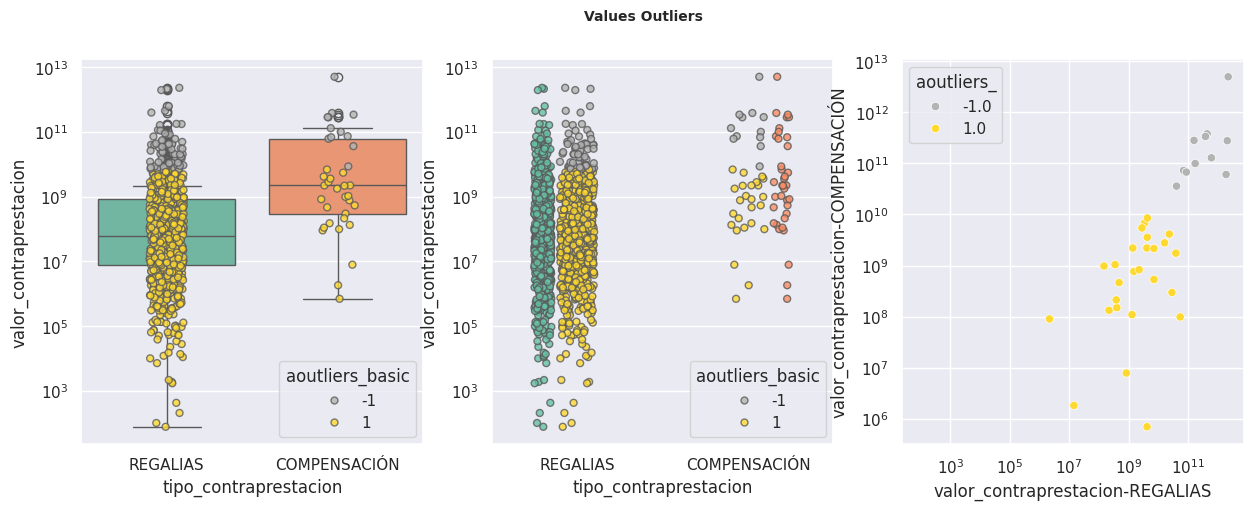

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=data_group2,
            y='valor_contraprestacion',
            x='tipo_contraprestacion',
            ax=ax[0],
            palette=paleta)

sns.stripplot(
    data=data_group2[data_group2['aoutliers_basic'] != "-1"],
    y="valor_contraprestacion",
    x='tipo_contraprestacion',
    hue='aoutliers_basic',
    ax=ax[0],
    linewidth=1,
    alpha = 0.8,
    palette=paleta[::-2])

ax[0].set(yscale="log")

sns.stripplot(
    data=data_group2,
    y="valor_contraprestacion",
    x='tipo_contraprestacion',
    dodge=True,
    ax=ax[1],
    linewidth=1,
    alpha = 0.8,
    palette=paleta)

sns.stripplot(
    data=data_group2[data_group2['aoutliers_basic'] != "-1"],
    y="valor_contraprestacion",
    x='tipo_contraprestacion',
    hue='aoutliers_basic',
    ax=ax[1],
    linewidth=1,
    alpha = 0.8,
    palette=paleta[::-2])
ax[1].set(yscale="log")

sns.scatterplot(
    data= data_group2pivot,
    x="valor_contraprestacion-REGALIAS",
    y="valor_contraprestacion-COMPENSACIÓN",
    ax=ax[2], hue='aoutliers_',
    palette=paleta[::-2])
ax[2].set(yscale="log")
ax[2].set(xscale="log")

fig.suptitle('Values Outliers', fontsize = 10, fontweight = "bold");
plt.show()

In [ ]:
score_anomalia = model_aoutliers_baseic.score_samples(X=data_group2[['valor_contraprestacion']])
np.quantile(score_anomalia, q=0.01)

-0.7865523257462551

In [ ]:
np.quantile(score_anomalia, q=model_aoutliers_baseic.contamination)

-0.5020455006684125

In [ ]:
model_aoutliers_baseic.offset_

-0.5020455006684125

Entre más baja sea la contaminación, más cercano a -1 es el umbral, por lo tanto, los atípicos tienen un score cercano a -1. Entre más grande la contaminación, más cercano a 0 es el umbral.

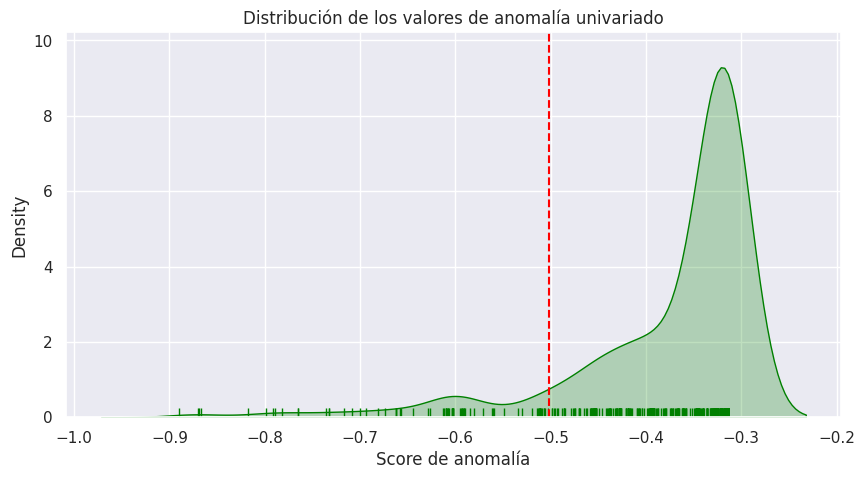

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.distplot(
    score_anomalia,
    hist    = False,
    rug     = True,
    color   = 'green',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.axvline(model_aoutliers_baseic.offset_, c='red', linestyle='--', label='cuantil 0.01')
ax.set_title('Distribución de los valores de anomalía univariado')
ax.set_xlabel('Score de anomalía');

# **Info**
---

**@By**: Steven Bernal

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr
